In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *
%matplotlib inline

/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWar

In [2]:
df = pd.read_csv('train_20171226.csv')

/home/yuanhao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['sale_date']=pd.to_datetime(df['sale_date'], format='%Y%m')
df['price']=pd.to_numeric(df['price'],errors='coerce')

In [4]:
df_test = pd.read_csv('testA_20171225.csv')

df_test.head()

,predict_date,class_id,predict_quantity
0,201711,103507,NaN
1,201711,124140,NaN
2,201711,125403,NaN
3,201711,136916,NaN
4,201711,169673,NaN


In [5]:
sale_class_date = df[['sale_quantity', 'class_id', 'sale_date']].groupby(['class_id','sale_date']).sale_quantity.agg('sum')

## step 1

In [8]:
def quantity_feature(data, months, end_date):
    start_date = end_date + DateOffset(months=-months)
    data_temp = data[(data['sale_date']>=start_date) & (data['sale_date']<end_date)]
    result = data_temp.groupby(['class_id']).sale_quantity.agg({'mean%d'%months:'mean',
                                                                'median%d'%months: 'median',
                                                                'min%d'%months: 'min',
                                                                'max%d'%months: 'max',
                                                                'std%d'%months: 'std',
                                                                'count%d'%months: 'count',
                                                                'skew%d'%months: 'skew'})
    result['date'] = end_date
    return result

In [12]:
def ratio_feature(data):
    data['mean2_3'] = data['mean2']/(data['mean3']+1)
    data['mean2_6'] = data['mean2']/(data['mean6']+1)
    data['mean2_12'] = data['mean2']/(data['mean12']+1)
    data['mean3_6'] = data['mean3']/(data['mean6']+1)
    data['mean3_12'] = data['mean3']/(data['mean12']+1)
    return data

In [10]:
reset_scd = sale_class_date.reset_index()
lagging_features = []

for date in df['sale_date'].dt.date.unique():
    month_feature = []
    for month in [2,3,6,12,18,24,100]:
        month_feature.append(quantity_feature(reset_scd, month, date))
    temp = pd.concat(month_feature, axis=1)
    temp = temp.loc[:,~temp.columns.duplicated()]
    lagging_features.append(temp.copy())


/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [15]:
lagging_features_df = pd.concat(lagging_features, axis=0).reset_index()
lagging_features_df = ratio_feature(lagging_features_df)

In [17]:
cols = ['current_sale','last_month_sale','last_year_sale','e_year','e_month',
        'month','year','class_id','last_month_price','last_year_price', 'price_delta', 
        'holidays','holiday_importance','weekend','length','workday','virtual_date']
dataset = {}
for c in cols:
    dataset[c]=[]

In [18]:
core_cols = ['current_sale','last_month_sale','last_year_sale','last_3m_avg','e_year','e_month',
            'last_month_price','last_year_price','price_delta','holidays','holiday_importance']

In [19]:
price_date = df[['price','class_id','sale_date']].groupby(['class_id','sale_date']).price.agg('mean')

In [20]:
holiday_df = pd.read_csv('holiday.csv')
holiday_df['date'] = pd.to_datetime(holiday_df['date'],format='%Y%m')

In [22]:
for idx, row in holiday_df.iterrows():
    if row['important']==1:
        if row.date.month in [4,5]:
            holiday_df.loc[idx, 'important'] = 2
        if row.date.month in [9,10]:
            holiday_df.loc[idx, 'important'] = 3

In [23]:
holiday_df.set_index('date', inplace=True)

In [26]:
count = 0
max_value = sale_class_date.max()
for c in sale_class_date.index.levels[0]:
    for t in sale_class_date[c].index:
        count +=1
        dataset['current_sale'].append(sale_class_date[c][t])
        dataset['month'].append(t.month)
        dataset['year'].append(t.year)
        dataset['class_id'].append(c)
        dataset['virtual_date'].append(t)
        l3_total, l3_count = 0, 0
        
        last_month = t + DateOffset(months=-1)
        if last_month in sale_class_date[c].index:
            dataset['last_month_sale'].append(sale_class_date[c][last_month])
            l3_total += sale_class_date[c][last_month]
            l3_count += 1
        else:
            dataset['last_month_sale'].append(np.nan)
            
        last_year = t + DateOffset(years = -1)
        if last_year in sale_class_date[c].index:
            dataset['last_year_sale'].append(sale_class_date[c][last_year])
        else:
            dataset['last_year_sale'].append(np.nan)
            
        lalm = last_year + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_year in sale_class_date[c].index and lalm in sale_class_date[c].index:
            dataset['e_year'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_year]/sale_class_date[c][lalm]))
        else:
            dataset['e_year'].append(np.nan)
            
        last_two_month = last_month + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_two_month in sale_class_date[c].index:
            dataset['e_month'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_month]/sale_class_date[c][last_two_month]))
        else:
            dataset['e_month'].append(np.nan)
            
        if last_month in price_date[c].index:
            dataset['last_month_price'].append(price_date[c][last_month])
        else:
            dataset['last_month_price'].append(np.nan)
            
        if last_year in price_date[c].index:
            dataset['last_year_price'].append(price_date[c][last_year])
        else:
            dataset['last_year_price'].append(np.nan)
            
        dataset['price_delta'].append(dataset['last_month_price'][-1] - dataset['last_year_price'][-1])
        
        dataset['holidays'].append(holiday_df.loc[t,'holidays'])
        dataset['holiday_importance'].append(holiday_df.loc[t,'important'])
        
        temp = t
        weekend = 0
        length = 0
        while temp.month==t.month:
            length+=1
            if temp.weekday() >=5:
                weekend+=1
            temp += DateOffset(days=1)
        dataset['weekend'].append(weekend)
        dataset['length'].append(length)
        dataset['workday'].append(length-weekend-holiday_df.loc[t,'holidays'])
print(count)

5587


In [27]:
data_df = pd.DataFrame(dataset, columns=cols)

In [28]:
data_df['virtual_date'] = data_df['virtual_date'].dt.date

In [30]:
data_df['sin_month'] = np.sin(data_df['month']*np.pi/12)

In [32]:
data_df.columns

Index(['current_sale', 'last_month_sale', 'last_year_sale', 'e_year',
       'e_month', 'month', 'year', 'class_id', 'last_month_price',
       'last_year_price', 'price_delta', 'holidays', 'holiday_importance',
       'weekend', 'length', 'workday', 'virtual_date', 'sin_month'],
      dtype='object')

In [33]:
lagging_features_df.columns

Index(['class_id', 'mean2', 'median2', 'min2', 'max2', 'std2', 'count2',
       'skew2', 'date', 'mean3', 'median3', 'min3', 'max3', 'std3', 'count3',
       'skew3', 'mean6', 'median6', 'min6', 'max6', 'std6', 'count6', 'skew6',
       'mean12', 'median12', 'min12', 'max12', 'std12', 'count12', 'skew12',
       'mean18', 'median18', 'min18', 'max18', 'std18', 'count18', 'skew18',
       'mean24', 'median24', 'min24', 'max24', 'std24', 'count24', 'skew24',
       'mean100', 'median100', 'min100', 'max100', 'std100', 'count100',
       'skew100', 'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6', 'mean3_12'],
      dtype='object')

In [34]:
data_df = data_df.merge(lagging_features_df, left_on=['class_id','virtual_date'], right_on=['class_id','date'], 
                        how='left')

In [35]:
data_df.drop(['virtual_date','date'], axis=1, inplace=True)

In [36]:
with open('data_df.pkl', 'wb') as f:
    pickle.dump(data_df, f, protocol=pickle.HIGHEST_PROTOCOL)

## CV

In [40]:
from sklearn.neural_network import MLPRegressor

In [41]:
validation_df = data_df[(data_df['month']==10)&(data_df['year']==2017)]

train_df = data_df[~((data_df['month']==10)&(data_df['year']==2017))]

train_X = train_df.drop(['current_sale'], axis=1)
train_Y = train_df['current_sale']

In [42]:
test_X = validation_df.drop(['current_sale'], axis=1)
test_Y = validation_df['current_sale']

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [103]:
parameters = {'learning_rate':[0.01,0.015,0.02],
              'n_estimators':[400,800,1200,1600],
              'subsample': [0.8],
              'num_leaves': [30,50,70,100],
              'colsample_bytree': [0.4,0.6,0.8],
              'min_child_samples': [5, 10, 20, 40],
              'n_jobs': [1],
              'random_seed': [1]
             }    
lgb = LGBMRegressor()
idx = ((data_df['month']==10)&(data_df['year']==2017)).astype(np.int)-1

In [106]:
clf = GridSearchCV(estimator=lgb, param_grid=parameters, n_jobs=-1, cv = PredefinedSplit(idx.values),
                  scoring='neg_mean_squared_error', verbose=3)
clf.fit(data_df.drop('current_sale', axis=1), data_df['current_sale'])

Fitting 1 folds for each of 576 candidates, totalling 576 fits
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jo

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   35.2s


[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18926.727909, total=  21.0s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16871.832303, total=   6.9s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-19550.683469, total=  29.4s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning

[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-17764.136721, total=  37.3s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15765.089999, total=  19.6s
[CV] colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15035.850488, total=  13.7s
[CV] colsample_bytree=0.4, learning

[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.01, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16983.368543, total=  26.5s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-17884.137032, total=  13.9s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17318.610050, total=  10.3s
[CV] colsample_bytree=0.4, learnin

[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18794.406253, total=  20.5s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15353.252315, total=   6.5s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-14881.779261, total=   8.6s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, lea

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.1min


[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16950.560412, total=   6.7s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-14145.345920, total=  19.6s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-14988.398076, total=  25.9s
[CV] colsample_bytree=0.4, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, 

[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16662.660881, total=   3.5s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-19234.227738, total=  13.8s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17991.084027, total=   5.3s
[CV] colsample_bytree=0.4, learning_rat

[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16416.534724, total=  25.8s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-16186.698492, total=  13.2s
[CV] colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15202.747418, total=  10.1s
[CV] colsample_bytree=0.4, learnin

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.4, learning_rate=0.02, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-15675.858093, total=  20.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18791.141139, total=   8.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-19774.880714, total=   9.2s
[CV] colsample_bytree=0.6, learning_rate=0

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17140.454497, total=  19.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-20444.574257, total=  47.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-14991.565502, total=   4.1s
[CV] colsample_bytree=0.6, learning_

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-15741.578661, total=  31.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17854.955549, total=  12.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15166.677822, total=  32.4s
[CV] colsample_bytree=0.6, learni

[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-20081.473621, total=   6.5s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-17743.810396, total=  26.1s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-19287.514594, total=   8.5s
[CV] colsample_bytree=0.6, learni

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.3min


[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17748.563206, total=  26.2s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-20008.700647, total=  12.9s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18513.500319, total=  35.1s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, l

[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14866.585767, total=  24.0s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-13916.084904, total=  16.5s
[CV] colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-19018.352456, total=   6.0s
[CV] colsample_bytree=0.6, lear

[CV]  colsample_bytree=0.6, learning_rate=0.015, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15914.997224, total=  31.1s
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-21564.452087, total=  12.6s
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-17928.109312, total=  17.2s
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_ra

[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14712.778372, total=   8.6s
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18198.123554, total=  24.1s
[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-15399.924461, total=  10.7s
[CV] colsample_bytree=0.6, learning_r

[CV] colsample_bytree=0.6, learning_rate=0.02, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-15022.149404, total=  18.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17024.546743, total=   5.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.6, learning_rate=0.02, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-15319.932051, total=  23.5s
[CV] colsample_bytree=0.8, learning_rat

[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18464.136951, total=  15.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-18912.439711, total=  44.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=10, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-18799.975726, total=  14.5s
[CV] colsample_bytree=0.8, learnin

[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14588.496577, total=  28.6s
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-18320.728351, total=   7.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18615.420109, total=   9.0s
[CV] colsample_bytree=0.8, learning_ra

[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18512.394091, total=  20.7s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.01, min_child_samples=40, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-16492.816364, total=  40.9s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=5, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-17818.345225, total=  28.3s
[CV] colsample_bytree=0.8, learni

[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-16402.792198, total=  12.6s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-17667.467210, total=  30.3s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-15396.560920, total=   9.5s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, l

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 20.7min


[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=800, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-16898.643668, total=   9.3s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8, score=-14867.027464, total=  28.8s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.015, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8, score=-15798.531507, total=  39.3s
[CV] colsample_bytree=0.8, learning_rate=0.015, min_child_samples=40, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, 

[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-20967.568966, total=   5.0s
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=5, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-17783.402449, total=  19.6s
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=400, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=5, n_estimators=1200, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-18449.197011, total=  30.8s
[CV] colsample_bytree=0.8, learning_rat

[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=100, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=10, n_estimators=1600, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-17953.661488, total=  38.5s
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1200, n_jobs=1, num_leaves=30, random_seed=1, subsample=0.8, score=-14815.803068, total=  14.4s
[CV] colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=1600, n_jobs=1, num_leaves=50, random_seed=1, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.02, min_child_samples=20, n_estimators=800, n_jobs=1, num_leaves=70, random_seed=1, subsample=0.8, score=-14621.504291, total=  19.1s
[CV] colsample_bytree=0.8, learnin

[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 24.6min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.015, 0.02], 'n_estimators': [400, 800, 1200, 1600], 'subsample': [0.8], 'num_leaves': [30, 50, 70, 100], 'colsample_bytree': [0.4, 0.6, 0.8], 'min_child_samples': [5, 10, 20, 40], 'n_jobs': [1], 'random_seed': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [108]:
clf.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.015,
 'min_child_samples': 20,
 'n_estimators': 1600,
 'n_jobs': 1,
 'num_leaves': 30,
 'random_seed': 1,
 'subsample': 0.8}

In [195]:
predict = 0
bagging_num = 1
for i in range(bagging_num):
    model1 = LGBMRegressor(learning_rate=0.015, n_estimators=1600, subsample=0.8, num_leaves=30+i, 
                           colsample_bytree=0.4, min_child_samples=20, reg_lambda=0.0001, random_seed=i)
    model2 = CatBoostRegressor(iterations=1400, learning_rate=0.01, depth=6, random_seed=i,
                               l2_leaf_reg=4, loss_function='RMSE', eval_metric='RMSE',logging_level='Silent')
    
    model2.fit(train_X.fillna(-99999), np.log10(train_Y), cat_features=[6])
    predict += np.power(10,model2.predict(test_X.fillna(-99999)))
    
    model1.fit(train_X.fillna(-99999), train_Y)
    predict += model1.predict(test_X.fillna(-99999))

predict = predict/bagging_num/2

In [196]:
mse = mean_squared_error(test_Y.values, predict)
print(np.sqrt(mse))

101.674998237


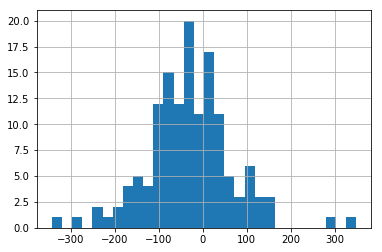

In [197]:
pd.Series((test_Y-predict)).hist(bins =30)

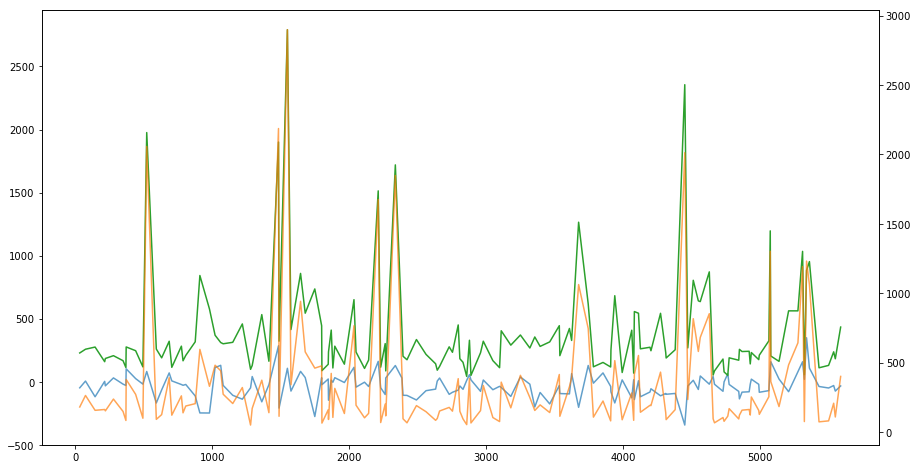

In [198]:
ax = pd.Series((test_Y-predict)).plot(figsize=(15,8),  alpha=0.7)
test_Y.plot(ax=ax, secondary_y=True, alpha=0.7)
pd.Series(predict,index=test_Y.index).plot(ax=ax)

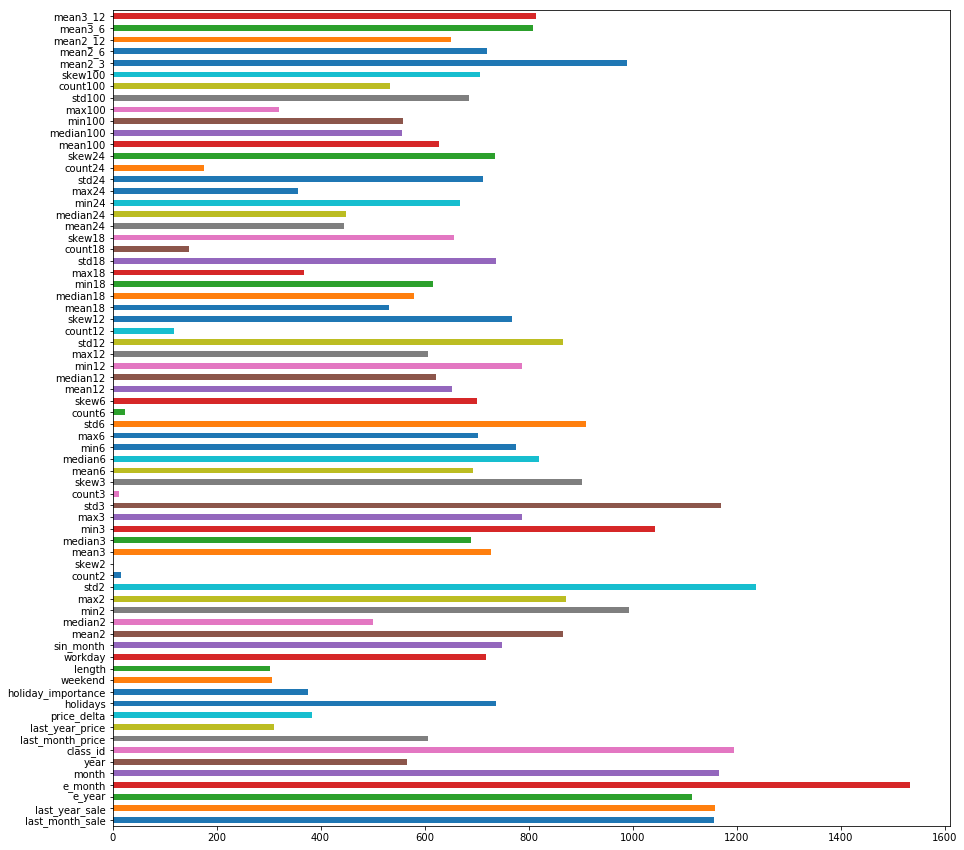

In [142]:
pd.Series(model1.feature_importances_, index=train_X.columns).plot.barh(figsize=(15,15))

## test

In [199]:
dataset_t = {}
for c in cols:
    dataset_t[c]=[]

In [200]:
count = 0
max_value = sale_class_date.max()
for c in sale_class_date.index.levels[0]:
        t = datetime.datetime(2017, 11, 1, 0, 0, 0)
        count +=1
        dataset_t['current_sale'].append(0)
        dataset_t['month'].append(t.month)
        dataset_t['year'].append(t.year)
        dataset_t['class_id'].append(c)
        dataset_t['virtual_date'].append(t)
        l3_total, l3_count = 0, 0
        
        last_month = t + DateOffset(months=-1)
        if last_month in sale_class_date[c].index:
            dataset_t['last_month_sale'].append(sale_class_date[c][last_month])
            l3_total += sale_class_date[c][last_month]
            l3_count += 1
        else:
            dataset_t['last_month_sale'].append(np.nan)
            
        last_year = t + DateOffset(years = -1)
        if last_year in sale_class_date[c].index:
            dataset_t['last_year_sale'].append(sale_class_date[c][last_year])
        else:
            dataset_t['last_year_sale'].append(np.nan)
            
        lalm = last_year + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_year in sale_class_date[c].index and lalm in sale_class_date[c].index:
            dataset_t['e_year'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_year]/sale_class_date[c][lalm]))
        else:
            dataset_t['e_year'].append(np.nan)
            
        last_two_month = last_month + DateOffset(months = -1)
        if last_month in sale_class_date[c].index and last_two_month in sale_class_date[c].index:
            dataset_t['e_month'].append(np.minimum(max_value,sale_class_date[c][last_month]*sale_class_date[c][last_month]/sale_class_date[c][last_two_month]))
        else:
            dataset_t['e_month'].append(np.nan)
        
        if last_month in price_date[c].index:
            dataset_t['last_month_price'].append(price_date[c][last_month])
        else:
            dataset_t['last_month_price'].append(np.nan)
            
        if last_year in price_date[c].index:
            dataset_t['last_year_price'].append(price_date[c][last_year])
        else:
            dataset_t['last_year_price'].append(np.nan)
            
        dataset_t['price_delta'].append(dataset_t['last_month_price'][-1] - dataset_t['last_year_price'][-1])
        
        dataset_t['holidays'].append(holiday_df.loc[t,'holidays'])
        dataset_t['holiday_importance'].append(holiday_df.loc[t,'important'])
                
        temp = t
        weekend = 0
        length = 0
        while temp.month==t.month:
            length+=1
            if temp.weekday() >=5:
                weekend+=1
            temp += DateOffset(days=1)
        dataset_t['weekend'].append(weekend)
        dataset_t['length'].append(length)
        dataset_t['workday'].append(length-weekend-holiday_df.loc[t,'holidays'])
print(count)

140


In [210]:
test_df = pd.DataFrame(dataset_t, columns=cols)

In [227]:
test_df.columns

Index(['current_sale', 'last_month_sale', 'last_year_sale', 'e_year',
       'e_month', 'month', 'year', 'class_id', 'last_month_price',
       'last_year_price', 'price_delta', 'holidays', 'holiday_importance',
       'weekend', 'length', 'workday', 'mean2', 'median2', 'min2', 'max2',
       'std2', 'count2', 'skew2', 'mean3', 'median3', 'min3', 'max3', 'std3',
       'count3', 'skew3', 'mean6', 'median6', 'min6', 'max6', 'std6', 'count6',
       'skew6', 'mean12', 'median12', 'min12', 'max12', 'std12', 'count12',
       'skew12', 'mean18', 'median18', 'min18', 'max18', 'std18', 'count18',
       'skew18', 'mean24', 'median24', 'min24', 'max24', 'std24', 'count24',
       'skew24', 'mean100', 'median100', 'min100', 'max100', 'std100',
       'count100', 'skew100', 'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6',
       'mean3_12', 'sin_month'],
      dtype='object')

In [212]:
test_df['virtual_date'] = test_df['virtual_date'].dt.date

In [213]:
test_df.head()

,current_sale,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,holidays,holiday_importance,weekend,length,workday,virtual_date
0,0,180,876.0,249.493671,174.193548,11,2017,103507,10.0,13.8,-3.8,0,0,8,30,22,2017-11-01
1,0,263,301.0,270.180887,242.698246,11,2017,124140,13.5,13.3,0.2,0,0,8,30,22,2017-11-01
2,0,156,131.0,206.424242,74.195122,11,2017,125403,24.3,45.0,-20.7,0,0,8,30,22,2017-11-01
3,0,162,213.0,191.700000,180.993103,11,2017,136916,16.6,17.6,-1.0,0,0,8,30,22,2017-11-01
4,0,152,NaN,NaN,105.497717,11,2017,169673,8.0,NaN,NaN,0,0,8,30,22,2017-11-01


In [214]:
lagging_features_test = []
reset_scd = sale_class_date.reset_index()

date = datetime.date(2017,11,1)
month_feature = []
for month in [2,3,6,12,18,24,100]:
    month_feature.append(quantity_feature(reset_scd, month, date))
temp = pd.concat(month_feature, axis=1)
temp = temp.loc[:,~temp.columns.duplicated()]
lagging_features_test.append(temp.copy())
lagging_features_test_df = pd.concat(lagging_features_test, axis=0).reset_index()
lagging_features_test_df = ratio_feature(lagging_features_test_df)

/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [215]:
test_df = test_df.merge(lagging_features_test_df, left_on=['class_id','virtual_date'], right_on=['class_id','date'], 
                        how='left')

In [216]:
test_df['sin_month'] = np.sin(test_df['month']*np.pi/12)
test_df.drop(['virtual_date','date'], axis=1, inplace=True)

In [240]:
test_df['mean6'].sort_values()

68       37.166667
39       40.000000
114      43.833333
112      48.666667
70       50.333333
95       53.333333
115      54.166667
53       59.750000
132      64.666667
48       70.400000
27       70.833333
93       72.000000
103      77.333333
111      84.333333
135      93.666667
10       97.166667
74       97.500000
61       98.666667
43      100.333333
7       102.500000
15      104.166667
60      105.000000
136     107.333333
51      107.500000
83      108.250000
88      110.500000
121     110.833333
41      111.500000
90      113.166667
4       116.200000
          ...     
82      479.500000
36      503.000000
97      533.500000
21      540.166667
29      556.000000
101     559.000000
129     560.500000
130     567.500000
92      589.333333
26      593.833333
108     605.166667
109     614.500000
87      652.166667
37      656.166667
46      730.666667
110     763.500000
107     779.000000
20      779.166667
35      784.500000
134     871.500000
133     947.666667
86     1000.

In [246]:

train_df = data_df

train_X = data_df.drop('current_sale', axis=1)
train_Y = data_df['current_sale']
test_X = test_df.drop('current_sale', axis=1)
predictor = train_X.columns.tolist()
predict = 0
bagging_num = 1
for i in range(bagging_num):
    model1 = LGBMRegressor(learning_rate=0.015, n_estimators=1600, subsample=0.8, num_leaves=30+i, 
                           colsample_bytree=0.4, min_child_samples=20, reg_lambda=0.0001, random_seed=i)
    model2 = CatBoostRegressor(iterations=1400, learning_rate=0.01, depth=6, random_seed=i,
                               l2_leaf_reg=4, loss_function='RMSE', eval_metric='RMSE',logging_level='Silent')
    
    model1.fit(train_X[predictor].fillna(-99999), (train_Y))
    model2.fit(train_X[predictor].fillna(-99999), np.log10(train_Y), cat_features=[6])
    predict += model1.predict(test_X[predictor].fillna(-99999)) 
    predict += np.power(10, model2.predict(test_X[predictor].fillna(-99999)))
predict = predict/bagging_num/2

In [254]:
test_X.columns

Index(['last_month_sale', 'last_year_sale', 'e_year', 'e_month', 'month',
       'year', 'class_id', 'last_month_price', 'last_year_price',
       'price_delta', 'holidays', 'holiday_importance', 'weekend', 'length',
       'workday', 'mean2', 'median2', 'min2', 'max2', 'std2', 'count2',
       'skew2', 'mean3', 'median3', 'min3', 'max3', 'std3', 'count3', 'skew3',
       'mean6', 'median6', 'min6', 'max6', 'std6', 'count6', 'skew6', 'mean12',
       'median12', 'min12', 'max12', 'std12', 'count12', 'skew12', 'mean18',
       'median18', 'min18', 'max18', 'std18', 'count18', 'skew18', 'mean24',
       'median24', 'min24', 'max24', 'std24', 'count24', 'skew24', 'mean100',
       'median100', 'min100', 'max100', 'std100', 'count100', 'skew100',
       'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6', 'mean3_12', 'sin_month'],
      dtype='object')

In [256]:
train_X.columns

Index(['last_month_sale', 'last_year_sale', 'e_year', 'e_month', 'month',
       'year', 'class_id', 'last_month_price', 'last_year_price',
       'price_delta', 'holidays', 'holiday_importance', 'weekend', 'length',
       'workday', 'sin_month', 'mean2', 'median2', 'min2', 'max2', 'std2',
       'count2', 'skew2', 'mean3', 'median3', 'min3', 'max3', 'std3', 'count3',
       'skew3', 'mean6', 'median6', 'min6', 'max6', 'std6', 'count6', 'skew6',
       'mean12', 'median12', 'min12', 'max12', 'std12', 'count12', 'skew12',
       'mean18', 'median18', 'min18', 'max18', 'std18', 'count18', 'skew18',
       'mean24', 'median24', 'min24', 'max24', 'std24', 'count24', 'skew24',
       'mean100', 'median100', 'min100', 'max100', 'std100', 'count100',
       'skew100', 'mean2_3', 'mean2_6', 'mean2_12', 'mean3_6', 'mean3_12'],
      dtype='object')

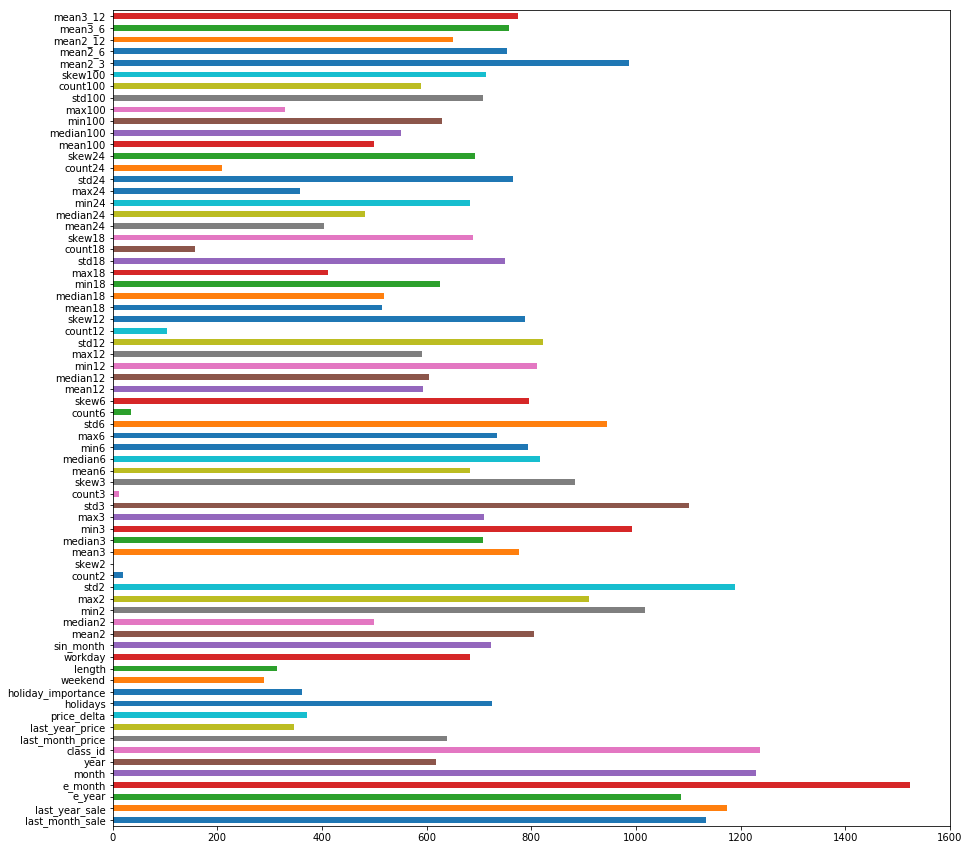

In [247]:
pd.Series(model1.feature_importances_, index=train_X[predictor].columns).plot.barh(figsize=(15,15))

In [222]:
test_X.head()

,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,price_delta,...,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12,sin_month
0,180,876.0,249.493671,174.193548,11,2017,103507,10.0,13.8,-3.8,...,1653,374.166890,32,1.372849,1.000000,0.659459,0.378947,0.655856,0.376877,0.258819
1,263,301.0,270.180887,242.698246,11,2017,124140,13.5,13.3,0.2,...,526,91.739079,42,0.014611,1.057915,1.057915,0.986203,0.996139,0.928614,0.258819
2,156,131.0,206.424242,74.195122,11,2017,125403,24.3,45.0,-20.7,...,418,75.993625,70,1.200444,0.909774,0.788702,0.921905,0.863661,1.009524,0.258819
3,162,213.0,191.700000,180.993103,11,2017,136916,16.6,17.6,-1.0,...,715,132.871645,70,1.129576,0.941718,0.925628,0.826380,0.976884,0.872140,0.258819
4,152,NaN,NaN,105.497717,11,2017,169673,8.0,NaN,NaN,...,219,68.349835,5,1.015397,1.209783,1.582765,1.582765,1.299772,1.299772,0.258819


In [224]:
data_df[(data_df['class_id']==103507) & (data_df['month']==10)]

,current_sale,last_month_sale,last_year_sale,e_year,e_month,month,year,class_id,last_month_price,last_year_price,...,min100,max100,std100,count100,skew100,mean2_3,mean2_6,mean2_12,mean3_6,mean3_12
7,1050,442.0,NaN,NaN,550.321127,10,2015,103507,14.9,NaN,...,58.0,442.0,119.800429,7.0,-0.564984,1.089790,1.296638,1.465843,1.186551,1.341391
19,632,684.0,1050.0,1624.886878,1152.354680,10,2016,103507,17.8,12.9,...,58.0,1433.0,364.504582,19.0,0.789069,1.111489,1.015528,0.744366,0.911801,0.668336
31,180,186.0,632.0,171.859649,192.200000,10,2017,103507,14.8,13.8,...,58.0,1653.0,374.643687,31.0,1.348530,0.804985,0.618592,0.351529,0.765070,0.434769


In [249]:
ans_df = pd.DataFrame()

ans_df['class_id']=test_df['class_id']
ans_df['predict_date']='201711'
ans_df['predict_quantity']=predict.astype(np.int)

ans_df.set_index('class_id',inplace=True)
ans_df.sort_index(inplace=True)

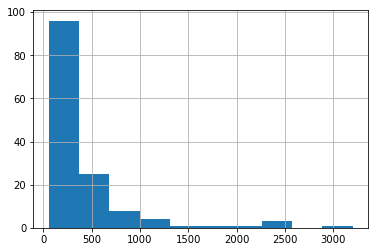

In [250]:
ans_df['predict_quantity'].hist()

In [257]:
ans_df.to_csv('predict_0209.csv')

In [252]:
ans_df['predict_quantity'].isnull().sum()

0

In [253]:
ans_df['predict_quantity'].sum()

55702

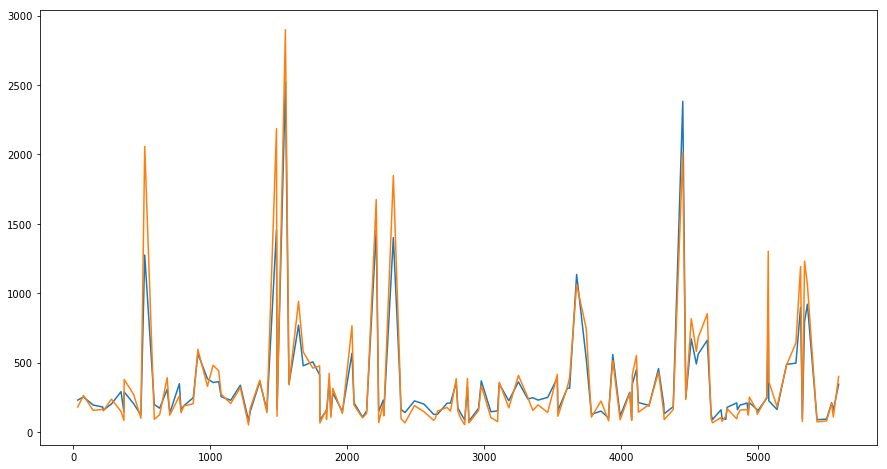

In [665]:
pd.Series(predict,index=test_Y.index).plot(figsize=(15,8))
pd.Series(test_Y).plot()